In [1]:
import shap
import pandas as pd
from sklearn.model_selection import train_test_split


from sklearn.tree import DecisionTreeClassifier, plot_tree
from pdpbox import pdp, info_plots
import numpy as np

from sklearn.metrics import (
    precision_recall_curve,
    accuracy_score,
    roc_auc_score,
    average_precision_score,
)
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

import sys
import os
import warnings


if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
path = "../01_clean_data/adult_ohe.csv"

adult_ohe = pd.read_csv(path)

X = adult_ohe.drop(columns=["income"])
y = adult_ohe["income"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [3]:
param_dist = {
    "criterion": ["gini", "entropy"],  # default: gini
    "max_depth": list(range(50, 1000, 100)) + [None],  # Default: None
    "min_samples_split": list(range(2, 20)),  # default: 2
    "min_samples_leaf": list(range(1, 20)),  # default: 1
    "max_features": list(range(1, 100)),  # default: None (All the features)
    "splitter": ["best", "random"],  # default: best
}

clf = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=1000,
    cv=5,
    scoring="roc_auc",
    random_state=42,
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_
best_params

{'splitter': 'best',
 'min_samples_split': 10,
 'min_samples_leaf': 19,
 'max_features': 22,
 'max_depth': 750,
 'criterion': 'entropy'}

In [4]:
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
auc_pr = average_precision_score(y_test, y_pred)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
auc_pr = average_precision_score(y_test, y_pred_proba)

# Max F1
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
max_f1_index = np.argmax(f1_scores)
max_threshold = thresholds[max_f1_index]
max_f1 = f1_scores[max_f1_index]

print(f"Max F1: {max_f1:.3f} at threshold {max_threshold:.3f}")
print(f"Average Precision Score: {auc_pr:.3f}")
print(f"AUC - ROC: {auc_roc:.3f}")
print(f"AUC - PR: {auc_pr:.3f}")
print(f"Accuracy: {accuracy:.3f}")

Max F1: 0.688 at threshold 0.375
Average Precision Score: 0.775
AUC - ROC: 0.898
AUC - PR: 0.775
Accuracy: 0.854


In [5]:
def f(x):
    return best_model.predict_proba(x)[:, 1]


med = X_train.median().values.reshape((1, X_train.shape[1]))

explainer = shap.Explainer(f, med)


shap_values = explainer(X_test)

PermutationExplainer explainer: 9770it [00:35, 207.16it/s]                          


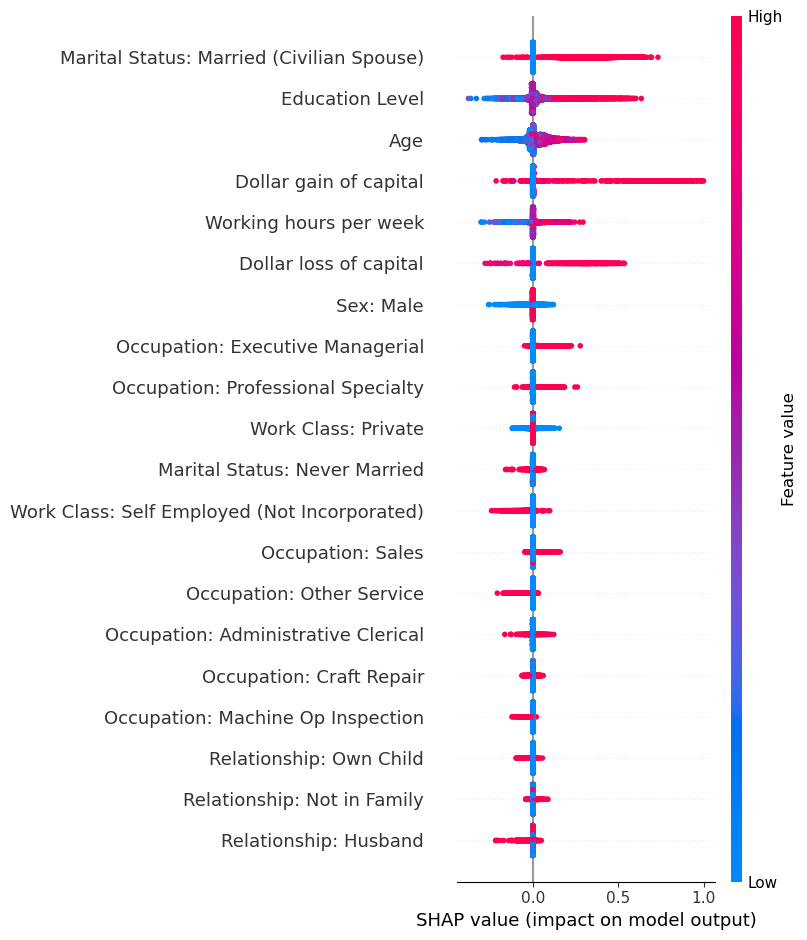

In [6]:
shap.summary_plot(shap_values, X_test)

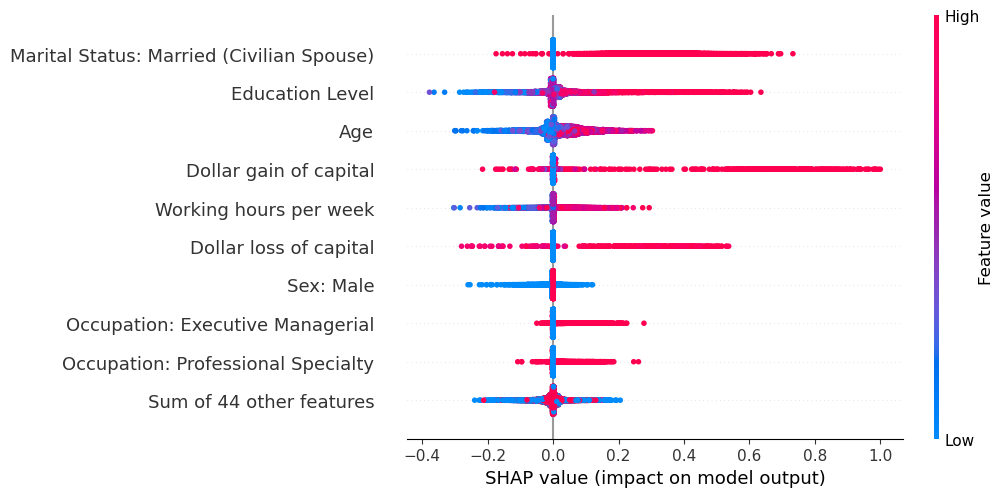

In [7]:
shap.plots.beeswarm(shap_values)

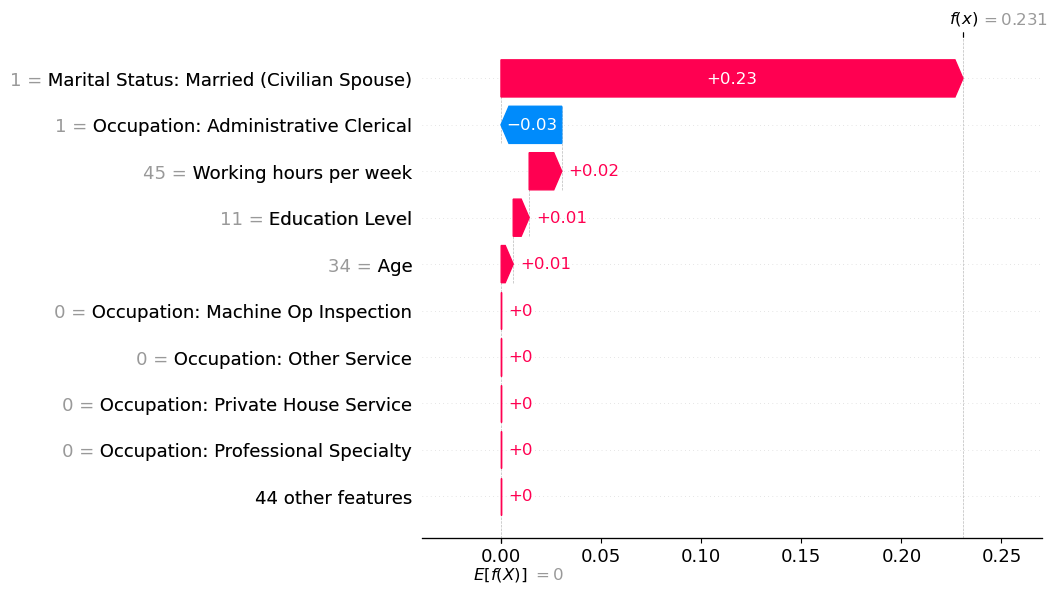

In [8]:
shap.plots.waterfall(shap_values[11])

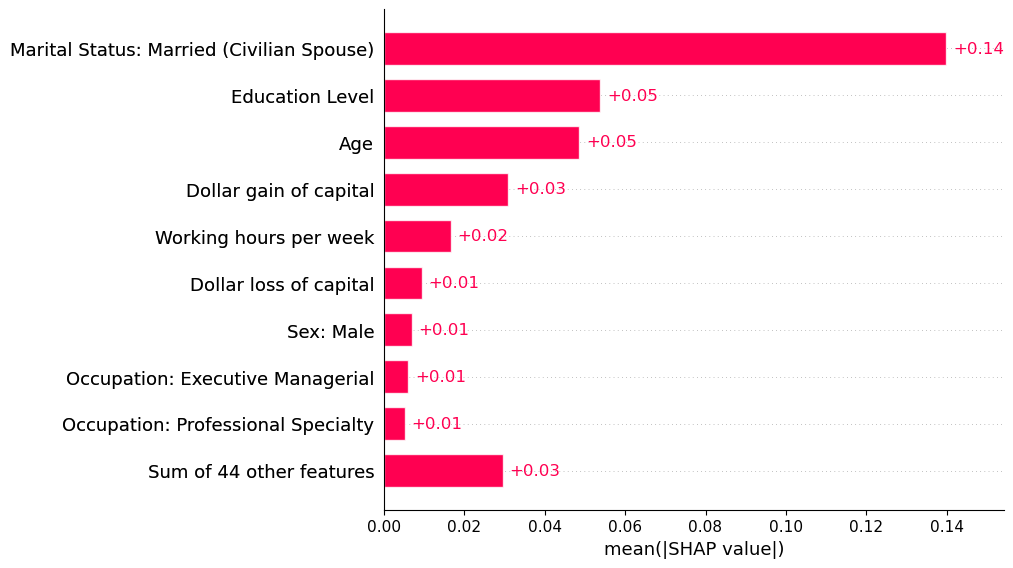

In [11]:
shap.plots.bar(shap_values)

In [10]:
# Result for AUC PR curves
results = pd.DataFrame({"score": y_pred_proba})
results.index.name = "id"
results.to_csv("../40_results/decision_tree_prob.csv")

# y test
results = pd.DataFrame({"score": y_test})
results.index.name = "id"
results.to_csv("../40_results/y_test.csv")